## nlbb technical challenge

Hi I am Bac. Here is my submission for the challenge. 

After talking with Marius I add:
- T-sne for features exploration.
- Fix some normalize error.
- Offer my opinions about this challenge. 

In [4]:
import datetime
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patheffects as PathEffects

from sklearn.manifold import TSNE
import seaborn as sns

%matplotlib inline

sns.set_style('darkgrid')
sns.set_palette('muted')
sns.set_context("notebook", font_scale=1.5,
                rc={"lines.linewidth": 2.5})

### Let check out the data

Do some basic sort and covert here

In [5]:
source_data = pd.read_csv("e_commerce_events_history.zip")
# Convert datetime column to datetime type
source_data["event_time"] = pd.to_datetime(
    source_data["event_time"]
)
# Sort data by time
source_data = source_data.sort_values("event_time")
source_data.head()

,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session
0,2020-09-24 11:57:06+00:00,view,1996170,2144415922528452715,electronics.telephone,NaN,31.90,1515915625519388267,LJuJVLEjPT
1,2020-09-24 11:57:26+00:00,view,139905,2144415926932472027,computers.components.cooler,zalman,17.16,1515915625519380411,tdicluNnRY
2,2020-09-24 11:57:27+00:00,view,215454,2144415927158964449,NaN,NaN,9.81,1515915625513238515,4TMArHtXQy
3,2020-09-24 11:57:33+00:00,view,635807,2144415923107266682,computers.peripherals.printer,pantum,113.81,1515915625519014356,aGFYrNgC08
4,2020-09-24 11:57:36+00:00,view,3658723,2144415921169498184,NaN,cameronsino,15.87,1515915625510743344,aa4mmk0kwQ


### Checking out some data properties

### Let see how many type of user interaction do we have


In [3]:
event_type_count = source_data.groupby("event_type")["event_type"].count()
event_type_count

event_type
cart         54035
purchase     37346
view        793748
Name: event_type, dtype: int64

#### => data have 3 types of interaction only

### Let see when user make purchase and how?
- We will show some sample of user session where user make the purchase

In [4]:
user_sessions_with_purchases = source_data.groupby("user_session").filter(
    lambda x: "purchase" in x["event_type"].values
)
user_sessions_with_purchases = user_sessions_with_purchases.groupby("user_session")

In [5]:
for i, (ss_key, user_session) in enumerate(user_sessions_with_purchases):
    print(user_session[["event_time", "event_type", "product_id"]], "\n")
    if i >=3:
        break

                      event_time event_type  product_id
222045 2020-11-06 04:40:04+00:00       view     1586099
222047 2020-11-06 04:40:50+00:00   purchase     1586099 

                      event_time event_type  product_id
837406 2021-02-20 08:55:48+00:00       view     1843522
837459 2021-02-20 09:05:14+00:00       view      631079
837461 2021-02-20 09:05:32+00:00       cart      631079
837467 2021-02-20 09:06:30+00:00   purchase      631079
837481 2021-02-20 09:08:41+00:00   purchase      631079 

                      event_time event_type  product_id
636687 2021-01-19 03:59:18+00:00       view      139173
636690 2021-01-19 04:00:45+00:00       cart      139173
636698 2021-01-19 04:04:12+00:00   purchase      139173
636739 2021-01-19 04:17:52+00:00   purchase      139173 

                      event_time event_type  product_id
253407 2020-11-10 18:18:45+00:00       view     4027952
253648 2020-11-10 18:52:05+00:00       view     4027952
253696 2020-11-10 19:02:50+00:00       car

#### => So mostly they have some view then make the purchase directly or adding to cart(no suprise)

### Distribution of number of customer interaction in the dataset

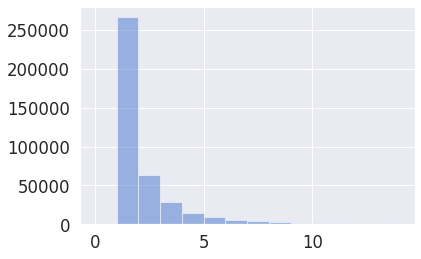

In [6]:
user_interaction_count = source_data.groupby("user_id")["user_id"].count()
bins = np.arange(0, 15, 1) # fixed bin size
num_interact_hist = plt.hist(user_interaction_count, bins=bins, alpha=0.5)

In [7]:
user_with_single_interaction = source_data.groupby("user_id").filter(lambda x: len(x)==1)
user_with_single_interaction["event_type"].value_counts()

view        266023
purchase       360
Name: event_type, dtype: int64

#### => So a big trunk is one time interaction
#### => most of them are view, we dont have data to predict in these case let's drop them

In [8]:
user_with_multiple_interaction = source_data.groupby("user_id").filter(lambda x: len(x)>1)
user_with_multiple_interaction["event_time"].max()

Timestamp('2021-02-28 23:59:09+0000', tz='UTC')

#### Define a start date for testing.

In [9]:
start_test_date = datetime.datetime(2021,1,1, tzinfo=datetime.timezone.utc)

### Let do some outlier cleaning
The only field with real value is price.

In [10]:
cleaning_data = user_with_multiple_interaction.copy()

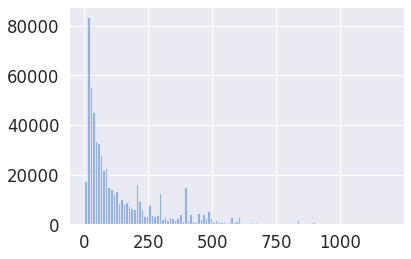

In [11]:
aprice = list(cleaning_data["price"])
bins = np.arange(0, 1200, 10) # fixed bin size
_ = plt.hist(aprice, bins=bins, alpha=0.5)

Move all outlier above 700USD to 700 USD

In [12]:
max_price = 700
bins = np.arange(0, 1200, 10) # fixed bin size
price_list = cleaning_data["price"]
price_clean = [price if price<max_price else max_price for price in price_list]
cleaning_data["price"] = price_clean
# _ = plt.hist(price_clean, bins=bins, alpha=0.5)

### Let normalize data
We can normalize the whole dataset since we know the max value for price is 700

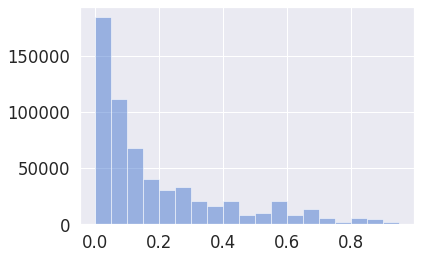

In [13]:
clean_data = cleaning_data.copy()
clean_data["price"] = [price/max_price for price in clean_data["price"]] 
bins = np.arange(0, 1, 0.05) # fixed bin size
_ = plt.hist(clean_data["price"], bins=bins, alpha=0.5)

### Let go with the most dirty solution
#### Let look at detail of last 10 interaction

#### Feature 1: Type of last 10 interactions
#### Feature 2: Normalize price of last 10 items checked
#### Feature 3: User pattern when interact(view the same product/category/brand or not)
    

In [14]:
from pandas.core.series import Series
def get_last_event_types(interactions: list[Series], depth: int = 10):
    """Type of interactions user done on the site."""
    last_events = [0] * depth
    event_map = {
        "view": 1,
        "cart": 2,
        "purchase": 3,
    }
    for i, action in enumerate(interactions):
        last_events[i] = event_map[action["event_type"]]
    return last_events
        
def get_last_price(interactions: list[Series], depth: int = 10):
    """Prices of last items user interact with."""
    last_prices = [0] * depth
    for i, action in enumerate(interactions):
        last_prices[i] = action["price"]
    return last_prices

def get_user_pattern(interactions: list[Series], pattern_name: str, depth: int =10):
    """Behaviors of user, where the they are checking the same items again or they are checking new one."""
    last_patterns = [0] * depth
    exist_items = []
    current_pattern = 0
    for i, action in enumerate(interactions):
        if action[pattern_name] not in exist_items:
            current_pattern +=1
            exist_items.append(action[pattern_name])

        last_patterns[i] = current_pattern    
    return last_patterns

def gen_feature_from_list_interaction(interactions: list[Series], depth=10):
    if not interactions:
        return None
    last_interaction = interactions[-depth:]
    last_interaction.reverse()
    event_types = get_last_event_types(last_interaction)
    prices = get_last_price(last_interaction)
    products = get_user_pattern(last_interaction, pattern_name="product_id")
    categories = get_user_pattern(last_interaction, pattern_name="category_code")
#     brands = get_user_pattern(last_interaction, pattern_name="brand")
#     sessions = get_user_pattern(last_interaction, pattern_name="user_session")

    return event_types + prices + products + categories

In [15]:
feature_data = []
label_data = []
event_time = []
user_ids = []
event_map = {
    "view": 0,
    "cart": 1,
    "purchase": 2, 
}


for i, (user_id, user_interact_df) in enumerate(clean_data.groupby("user_id")):
    prev_interaction = []
    for index, row in user_interact_df.iterrows():
        label = event_map[row["event_type"]]
        feature = gen_feature_from_list_interaction(prev_interaction)
        prev_interaction.append(row)
        if feature is None:
            continue
        feature_data.append(np.array(feature))
        label_data.append(label)
        event_time.append(row["event_time"])
        user_ids.append(row["user_id"])
#     if i > 10000:
#         break


In [16]:
data_for_model = pd.DataFrame.from_dict(
    {
        "features": feature_data,
        "labels": label_data,
        "event_time": event_time,
        "user_ids": user_ids,
    }
)
data_for_model.head()

,features,labels,event_time,user_ids
0,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0,2020-11-09 09:04:34+00:00,1515915625353230683
1,"[1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0,2020-11-09 09:08:53+00:00,1515915625353230683
2,"[1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0,2020-11-09 09:10:59+00:00,1515915625353230683
3,"[1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0,2020-11-09 09:15:27+00:00,1515915625353230683
4,"[1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...",0,2020-11-09 09:22:00+00:00,1515915625353230683


### Visualize some data to check features quality

In [17]:
def feature_scatter(x, colors):
    # choose a color palette with seaborn.
    num_classes = len(np.unique(colors))
    palette = np.array(sns.color_palette("hls", num_classes))

    # create a scatter plot.
    f = plt.figure(figsize=(8, 8))
    ax = plt.subplot(aspect='equal')
    sc = ax.scatter(x[:,0], x[:,1], lw=0, s=40, c=palette[colors.astype(np.int)])
    plt.xlim(-25, 25)
    plt.ylim(-25, 25)
    ax.axis('off')
    ax.axis('tight')

    # add the labels for each digit corresponding to the label
    txts = []

    for i in range(num_classes):

        # Position of each label at median of data points.

        xtext, ytext = np.median(x[colors == i, :], axis=0)
        txt = ax.text(xtext, ytext, str(i), fontsize=24)
        txt.set_path_effects([
            PathEffects.Stroke(linewidth=5, foreground="w"),
            PathEffects.Normal()])
        txts.append(txt)

    return f, ax, sc, txts


In [18]:
def vis_tsne_features(X, y):
    time_start = time.time()
    feat_tsne = TSNE(random_state=0).fit_transform(X)
    print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))
    feature_scatter(feat_tsne, y)

t-SNE done! Time elapsed: 43.93400311470032 seconds


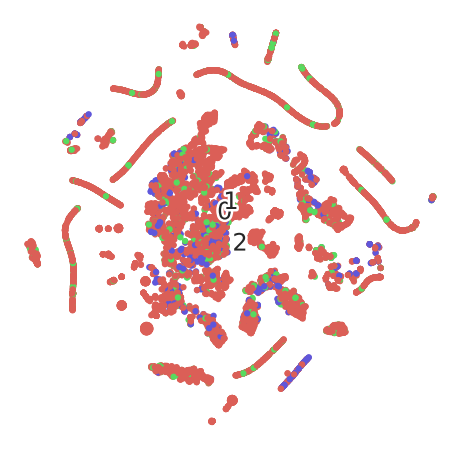

In [19]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

vis_sample_num = 10000
x_subset = np.array(list(data_for_model["features"]))[:vis_sample_num]
y_tsne = np.array(list(data_for_model["labels"]))[:vis_sample_num]
vis_tsne_features(x_subset, y_tsne)

#### RED = View, BLUE = Cart, GREEN = Purchase

#### Some analysis
#### The first thing is I dont think predict the "next action" is a good ideas because:

1. The next action is too abitrary, from the t-sne vis we can see that there are no distinstion between type of actions.(A reason is our features is not good enough but I dont think we can change much by update features).
2. There are not much business value in predict the next immediate action. In my opinion, somethink like:
- Predict whether user will continue have more interactions on the site.
- Predict purchase/cart action in next 10 interactions.

=> These kind of signal will have more business sense and we can predict with more accuracy.

### But let train a model anyway
### Split train - test data.

In [20]:
train_data = data_for_model[data_for_model["event_time"] < start_test_date]
test_data = data_for_model[data_for_model["event_time"] >= start_test_date]

### Train model 

In [21]:
from sklearn.linear_model import LogisticRegression
from sklearn import preprocessing

X_train = np.array(list(train_data["features"]))
y_train = np.array(list(train_data["labels"]))

scaler = preprocessing.StandardScaler().fit(X_train)
X_scaled = scaler.transform(X_train)

clf = LogisticRegression(random_state=0, solver="saga", max_iter=1e8).fit(X_scaled, y_train)


### Filter the the first user interaction for each users in the test set

In [22]:
user_groups = test_data.groupby("user_ids")
X_test = []
y_test = []
for user_id, interactions in user_groups:
    first_interaction = interactions.iloc[0]
    X_test.append(first_interaction["features"])
    y_test.append(first_interaction["labels"])

In [23]:
X_test = np.array(X_test)
y_test = np.array(y_test)

scaler_test = preprocessing.StandardScaler().fit(X_test)
X_test_scaled = scaler_test.transform(X_test)


In [24]:
y_pred = clf.predict(X_test_scaled)
y_pred
from collections import Counter
Counter(y_pred)


Counter({0: 55494, 2: 636, 1: 81})

In [25]:
Counter(y_test)

Counter({0: 48305, 1: 7694, 2: 212})

In [26]:
from sklearn.metrics import classification_report
target_names = ['view', 'cart', 'purchase']
report = classification_report(y_test, y_pred, target_names=target_names)

In [27]:
print(report)

              precision    recall  f1-score   support

        view       0.86      0.99      0.92     48305
        cart       0.00      0.00      0.00      7694
    purchase       0.06      0.19      0.10       212

    accuracy                           0.85     56211
   macro avg       0.31      0.39      0.34     56211
weighted avg       0.74      0.85      0.79     56211



### As expect the result is terrible. And we should re-consider this aproach